In [1]:
%load_ext autoreload
%autoreload 2
from astropy.table import Table
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm, trange
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import simulation as simulation
import pinocchio_binning_scheme as binning_scheme
import pyccl as ccl
from multiprocessing import Pool
import model_halo_abundance as cl_count
from matplotlib.cm import get_cmap
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize SBI object

In [2]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator_pl.selection_richness = 0
def dOmega_z(z): return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = None
stacked_simulator_pl.redshift_bins = None
stacked_simulator_pl.sigma_mwl = 0
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.2 , 15.5 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.f_sky = 0.25
stacked_simulator_pl.hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.poisson_only = False
stacked_simulator_pl.use_hybrid = True
stacked_simulator_pl.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_pl.Z_edges_hybrid[i], stacked_simulator_pl.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_hybrid)-1)]

# Compute (or load) fiducial Sij matrix

In [3]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [4]:
have_PySSC = False
if have_PySSC:
    stacked_simulator_pl.Sij_SSC = compute_Sij_matrix(cosmo, stacked_simulator_pl.Z_bin_SSC)/stacked_simulator_pl.f_sky
    save_pickle(stacked_simulator_pl.Sij_SSC*stacked_simulator_pl.f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl', )
else: 
    S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl' )
    stacked_simulator_pl.Sij_SSC = S_ij_full_sky/stacked_simulator_pl.f_sky

# Generate mass-redshift catalogue with SSC

In [5]:
%time Nth, z, log10m = stacked_simulator_pl.get_cluster_catalogue(cosmo,return_Nth = True)

CPU times: user 3.65 s, sys: 26.2 ms, total: 3.68 s
Wall time: 895 ms


In [6]:
Ncount_obs, a, b = np.histogram2d(z, log10m, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])

# Compare to standard approach

In [7]:
logm_edges = binning_scheme.logm_edges
redshift_edges = binning_scheme.redshift_edges
richness_edges = binning_scheme.richness_edges
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

In [8]:
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
clc = cl_count.ClusterAbundance()
z_grid = np.linspace(0.2, 1., 1000)
logm_grid = np.linspace(14.2, 15.5, 1001)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.sky_area = stacked_simulator_pl.f_sky * 4 * np.pi
Ncount_th = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


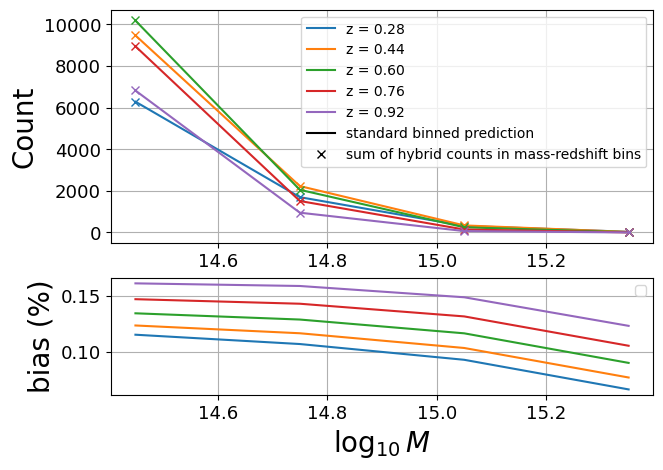

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(7,5), gridspec_kw={'height_ratios': [2,1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=None)

for j in range(2):
    ax[j].grid(which='both')
    ax[0].legend()
    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)
for i, z_bin in enumerate(Z_bin):
    Count_hybrid = []
    for logmass_bin in LogMass_bin:
        mask = (Nth['logm_grid_center'] > logmass_bin[0])*(Nth['logm_grid_center'] < logmass_bin[1])
        Count_hybrid.append(np.sum(Nth['N_th'][i,:][mask]))
    ax[0].plot(np.mean(LogMass_bin, axis=1), Count_hybrid, 'C'+str(i), ls = ' ', marker = 'x')
    ax[0].plot(np.mean(LogMass_bin, axis=1), Ncount_th[i,:], 'C'+str(i), ls = '-',  label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')
    ax[1].plot(np.mean(LogMass_bin, axis=1), 100*(np.array(Count_hybrid) - Ncount_th[i,:])/Ncount_th[i,:],'C'+str(i), )
ax[0].plot([], [], '-k', label = 'standard binned prediction')
ax[0].plot([], [], 'xk', label = 'sum of hybrid counts in mass-redshift bins')
ax[0].set_ylabel(r'Count', fontsize=20,)
ax[0].legend()
ax[1].set_xlabel(r'$\log_{10}M$', fontsize=20,)
ax[1].set_ylabel(r'bias (%)', fontsize=20,)
ax[1].legend()